In [80]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from lalframe.utils import frtools

### Getting Omicron triggers

(43590,)


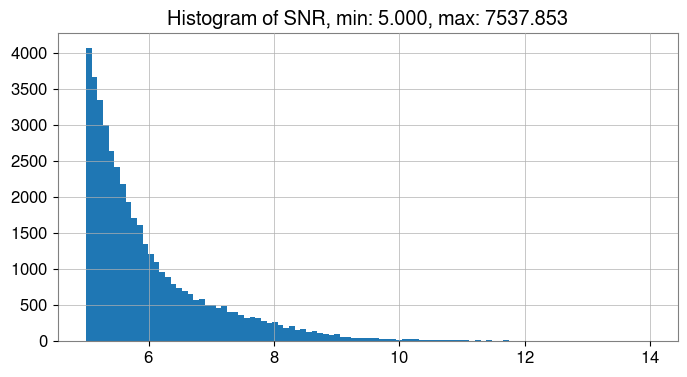

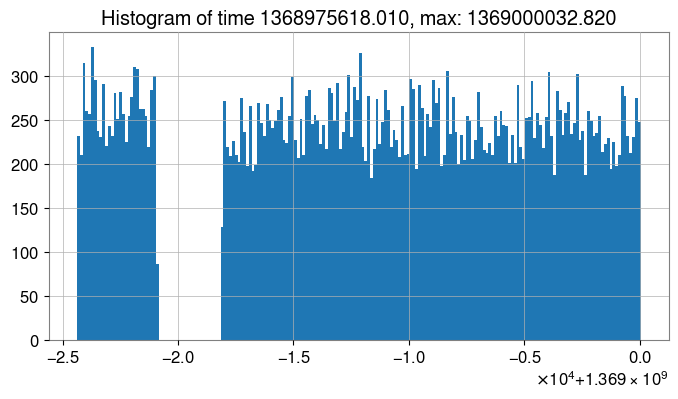

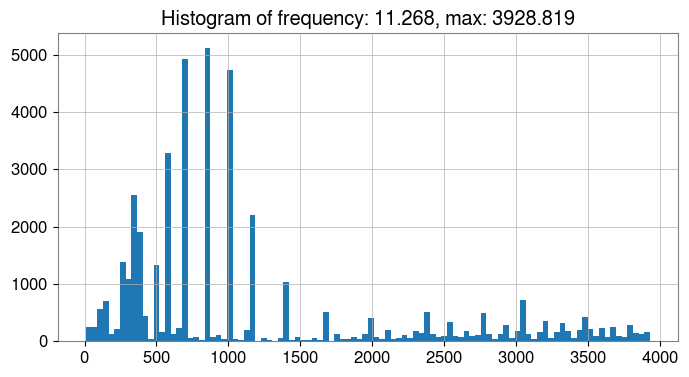

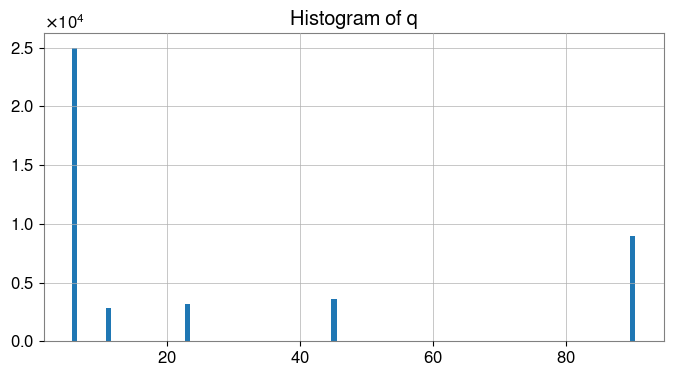

In [2]:
trigger_file = "./K1-HPF_4_filtered.hdf5"
with h5py.File(trigger_file, 'r') as f:
    triggers = f['triggers'][:]

print(triggers.shape)
snr = triggers['snr']
time = triggers['time']
frequency = triggers['frequency']
q = triggers['q']
plt.figure(figsize=[8,4])
plt.title(f"Histogram of SNR, min: {snr.min():.3f}, max: {snr.max():.3f}")
plt.hist(snr, bins=100, range=(5,14))
plt.show()

plt.figure(figsize=[8,4])
plt.title(f"Histogram of time {time.min():.3f}, max: {time.max():.3f}")
plt.hist(time, bins=200)
plt.show()

plt.figure(figsize=[8,4])
plt.title(f"Histogram of frequency: {frequency.min():.3f}, max: {frequency.max():.3f}")
plt.hist(frequency, bins=100)
plt.show()

plt.figure(figsize=[8,4])
plt.title(f"Histogram of q")
plt.hist(q, bins=100)
plt.show()

### Q-transform

In [82]:
# Find the segments of a given GPS
def find_segment(
    seg_file: str,
    time: float,
):
    with open(seg_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            start = float(line.strip().split(' ')[0])
            end = float(line.strip().split(' ')[1])
            if (time >= start) and (time <= end):
                seg = (start, end)
                break
            else:
                continue
            
        if seg is not None:
            return seg
        else:
            print(f"Cannot find the segment that {time} belongs to in {seg_file}.")

# Define a function to get the asd for whitening
def calculate_asd(
        source: list,
        channel: str,
        start: float,
        end: float,
        fftlength: float=32,
        overlap: float=16,
):
    ts = TimeSeries.read(
        source=source,
        channel=channel,
        start=start,
        end=end,
    )
    asd = ts.asd(
        fftlength=fftlength,
        overlap=overlap,
        method='median',
    )
    return asd

# Define a function to get all of the spectrogram
def calculate_spectrogram(
        source: list,
        channel: str,
        trigger_info,
        asd,
        window_length: float=2,
        crop_length: float=1,
        offset: float=0,
        qrange: tuple=(50,50),
        frange: tuple=(5, 1500),
        tres: float=1/200,
        fres: float=0.5,
):
    trigger_time = trigger_info['time']
    start = trigger_time - (window_length/2 + crop_length) + offset
    end = trigger_time + (window_length/2 + crop_length) + offset
    ts = TimeSeries.read(
        source=source,
        channel=channel,
        start=start,
        end=end,
    )
    wh_ts = ts.whiten(asd=asd)
    qspec = wh_ts.q_transform(
        qrange=qrange,
        frange=frange,
        tres=tres,
        logf=False,
        fres=fres,
        whiten=False,
    )
    qspec_crop = qspec.crop(start+crop_length, end-crop_length)
    return qspec_crop

### Filtering triggers by SNR

In [83]:
filter_id = []
for i, trigger in enumerate(triggers):
    if trigger['snr'] >= 6:
        filter_id.append(i)

filtered_triggers = triggers[filter_id]
print(filtered_triggers.shape)

(15526,)


In [85]:
channel = "K1:CAL-CS_PROC_DARM_STRAIN_DBL_DQ"
seg_file = "./K1-GRD_SCIENCE_MODE_NO_IPC_ERROR_SEGMENT_UTC_O4a.txt"
data_dir = "/data/KAGRA/raw/science"
id_start = 100
id_end = 200
output_dir = "/home/chia-jui.chou/glitch-data/K1-O4a"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
output_file = f"{output_dir}/K1_qspecs_snrge6_{id_start}-{id_end}.hdf5"

# Setting window lengths and the size of the spectrograms
window_lengths = [0.25, 0.5, 1, 2]
pixel_length = 400
tress = [window_length/pixel_length for window_length in window_lengths]
window_length_max = np.max(window_length)

# Processing data
merged_specs = []
for i in range(id_start, id_end):
    # Get the segment and the source of the time series
    trigger = filtered_triggers[i]
    seg = find_segment(seg_file, trigger['time'])
    # if trigger['time'] - window_length_max/2 < seg[0] or trigger['time'] + window_length_max/2 > seg[1]:
        # print(f"{trigger['time']} is too close to {seg[0]} or {seg[1]}.")
        # continue

    f_labels = [int(seg[0]/1e5), int(seg[1]/1e5)]
    if f_labels[1] > f_labels[0]:
        source = []
        for f_label in f_labels:
            gwfs = glob.glob(f"{data_dir}/{f_label}/*.gwf")
            source.extend(gwfs)
    
    else:
        source = glob.glob(f"{data_dir}/{f_labels[0]}/*.gwf")

    # ASD of the segment
    asd = calculate_asd(
        source=source,
        channel=channel,
        start=seg[0],
        end=seg[1],
    )

    # Calculate q-spectrograms
    output_qspecs = []
    for tres, window_length in zip(tress, window_lengths):
        # Setting parameters for Q-transform
        crop_length = 0.9
        offset = 0.0*window_length
        qrange = (50, 50)
        frange = (5, 1500)
        tres = tres
        fres = 5
        # Q-transform
        qspec = calculate_spectrogram(
            source=source,
            channel=channel,
            trigger_info=trigger,
            asd=asd,
            window_length=window_length,
            crop_length=crop_length,
            offset=offset,
            qrange=qrange,
            frange=frange,
            tres=tres,
            fres=fres,
        )
        output_qspecs.append(qspec)

    # Merge 4 spectrograms
    qspec_row_n = output_qspecs[0].T.value.shape[0]
    qspec_column_n = output_qspecs[0].T.value.shape[1]
    data_shape = (2*qspec_column_n, 2*qspec_row_n)
    merged_spec = np.zeros(shape=data_shape)
    merged_spec[:qspec_column_n, :qspec_row_n] = output_qspecs[0].value
    merged_spec[:qspec_column_n, qspec_row_n:] = output_qspecs[1].value
    merged_spec[qspec_column_n:, :qspec_row_n] = output_qspecs[2].value
    merged_spec[qspec_column_n:, qspec_row_n:] = output_qspecs[3].value

    # Append the merged spectrogram to a list merged_specs
    merged_specs.append(merged_spec)

# Save merged_specs to a hdf5 file
# output_file = f"./K1_qspecs_snrge6_{id_start}-{id_end}.hdf5"
with h5py.File(output_file, 'w') as f:
    trigger_data = filtered_triggers[id_start:id_end]
    f.create_dataset(
        "triggers",
        shape=trigger_data.shape,
        dtype=trigger_data.dtype,
        data=trigger_data,
    )

    qspec_data = np.stack(merged_specs)
    f.create_dataset(
        "qspecs",
        shape=qspec_data.shape,
        dtype=qspec_data.dtype,
        data=qspec_data,
    )
    f['qspecs'].attrs['channel'] = channel
    f['qspecs'].attrs['window_lengths'] = window_lengths
    f['qspecs'].attrs['crop_length'] = crop_length
    f['qspecs'].attrs['qrange'] = np.array(qrange)
    f['qspecs'].attrs['frange'] = np.array(frange)
    f['qspecs'].attrs['tres'] = np.array(tress)
    f['qspecs'].attrs['fres'] = fres

In [86]:
print(len(merged_specs))

100


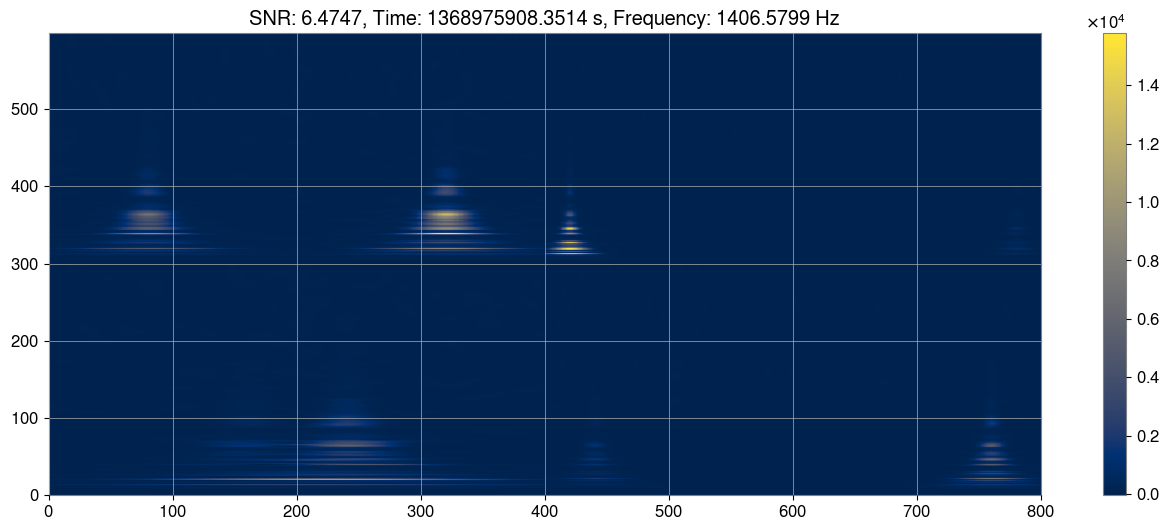

In [87]:
id_start, id_end = 100, 200
output_file = f"{output_dir}/K1_qspecs_snrge6_{id_start}-{id_end}.hdf5"
spec_id = 41
with h5py.File(output_file, 'r') as f:
    chosen_spec = f['qspecs'][spec_id]
    trigger = f['triggers'][spec_id]

plt.figure(figsize=[16,6])
plt.title(f"SNR: {trigger['snr']:.4f}, Time: {trigger['time']:.4f} s, Frequency: {trigger['frequency']:.4f} Hz")
plt.pcolormesh(
    chosen_spec.T,
    cmap='cividis',
)
plt.colorbar(cmap='cividis')
plt.show()